# LinRegProject

## Import Data

In [345]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import norm
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
import pickle
pd.pandas.set_option('display.max_columns', None)

%matplotlib inline

In [346]:
# Global Burden of Disease Collaborative Network. #
# Global Burden of Disease Study 2017 (GBD 2017) Results. #
# Seattle, United States: Institute for Health Metrics and Evaluation (IHME), 2018. #
# Available from http://ghdx.healthdata.org/gbd-results-tool. #
# Renamed to 'suicide_rates.csv' #
df1 = pd.read_csv('IHME-GBD_2017_DATA-f57da2bf-1.csv') # 2005-2016, from Global Health Data Exchange from WHO

# Kaggle World Happiness dataset #
df2 = pd.read_csv('world-happiness-report-2005-2018.csv', delimiter=';') # 2005-2018, from UN WHR

# Capitals from https://www.jasom.net/list-of-capital-cities-with-latitude-and-longitude/ #
df3 = pd.read_csv('capitals.csv')

### 2005-2016 merge ###
### Target Variable: Suicide Rates ###

## Cleaning Data/Merging Data

In [347]:
### Use columns of countries, year, suicide rate ###
df1 = df1[['location_name', 'year', 'val']]
df1 = df1.rename({'location_name': 'country', 'val': 'suicide_rate'}, axis=1)
### Suicides/100,000 ###

### Order DataFrame entries by country then year ###
df1 = pd.DataFrame(df1.groupby(['country', 'year'])['suicide_rate'].sum()).reset_index()

### Round suicide_rate to 2 significant digits ###
df1['suicide_rate'] = round(df1['suicide_rate'], 2)

In [348]:
### Match column names for join ###
df2.rename({'Country name': 'country', 'Year': 'year'}, axis=1, inplace=True)

In [349]:
### Index for join ###
df1 = df1.groupby(['country', 'year']).sum()
df2 = df2.groupby(['country', 'year']).sum()

In [350]:
### Join df1 and df2 ###
data = df1.join(df2)

In [351]:
### Drop Nan values (may add means later) ###
data.dropna(inplace=True)

### Keep relevant columns ###
data = data.iloc[:, 0:8]

In [352]:
### Add GDP/capita column from log(gdp/capita) ###
data['gdp_cap'] = np.exp(data['Log GDP per capita'])

### Round to 2 significant digits and reset index ###
data = round(data, 2)
data.reset_index(inplace=True)

In [353]:
### Drop irrelevant columns ###
df3.drop(columns='Capital', inplace=True)

In [354]:
### Rename column for merge ###
df3.rename({'Country': 'country'}, axis=1, inplace=True)

In [355]:
### Merge df3 onto data ###
data = data.merge(df3, on='country')

## EDA

In [360]:
## replace syria 2015 log gdp per capita with mean
## Drop Somalia


data.loc[data['country'] == 'Somalia']

,country,year,suicide_rate,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,gdp_cap,Latitude,Longitude\
1055,Somalia,2014,5.12,5.53,0.0,0.61,49.6,0.87,0.0,0.46,1.0,2.046934,45.318162\
1056,Somalia,2015,5.10,5.35,0.0,0.60,50.1,0.97,0.0,0.41,1.0,2.046934,45.318162\
1057,Somalia,2016,5.07,4.67,0.0,0.59,50.0,0.92,0.0,0.44,1.0,2.046934,45.318162\


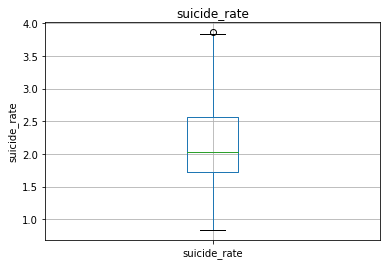

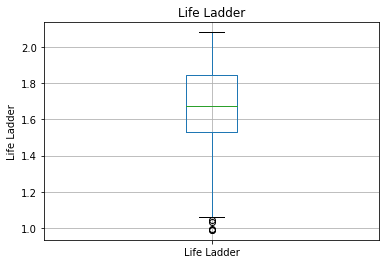

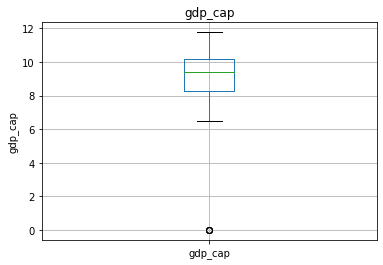

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


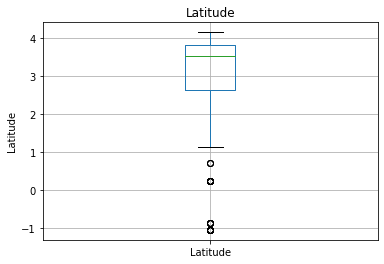

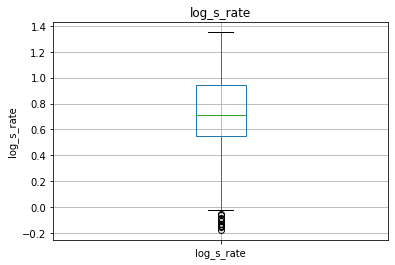

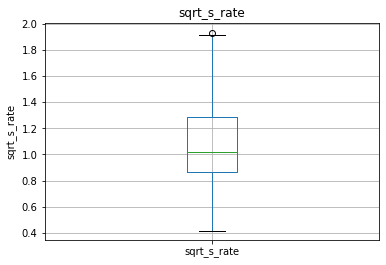

In [272]:
# let's make boxplots to visualise outliers in the continuous variables 

def find_outliers(df, var):
    df = data1.copy()
    
    # log does not take negative values, so let's be careful and skip those variables
    if 0 in data1[var].unique():
        pass
    else:
        df[var] = np.log(df[var])
        df.boxplot(column=var)
        plt.title(var)
        plt.ylabel(var)
        plt.show()
    
for var in data1:
    find_outliers(data, var)

In [246]:
#data2 = data.copy()
#data2 = data2.groupby('country').mean()
data['log_s_rate'] = np.log(data['suicide_rate'].values)
data['sqrt_s_rate'] = np.sqrt(data['suicide_rate'].values)

In [247]:
data1 = data.groupby(['country', 'year']).mean()

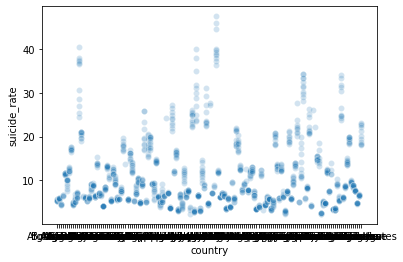

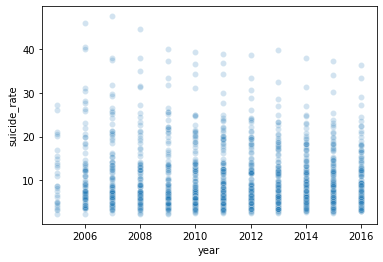

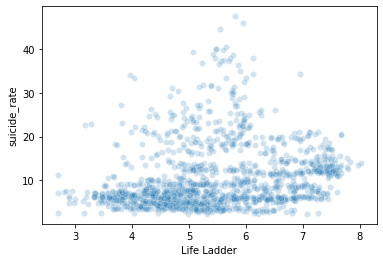

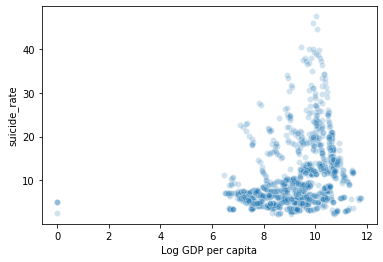

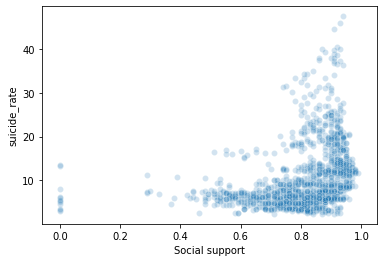

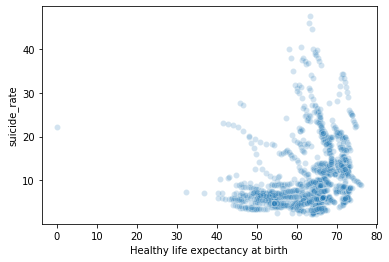

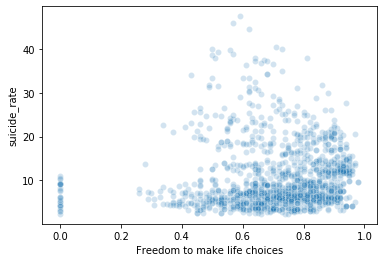

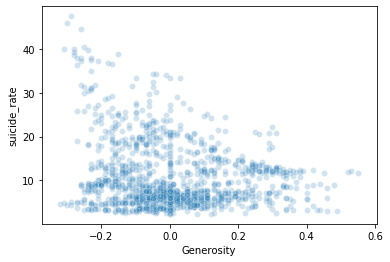

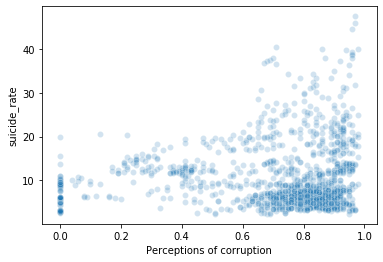

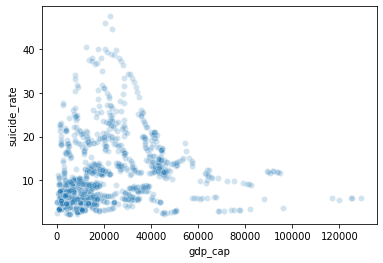

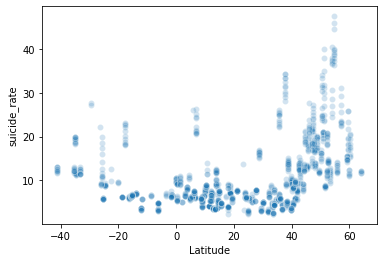

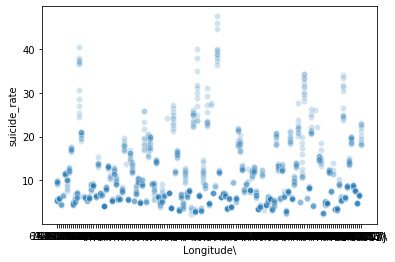

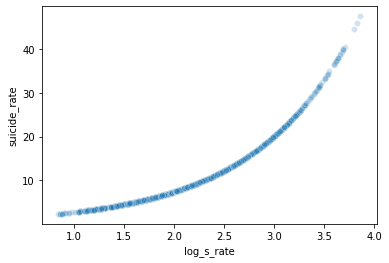

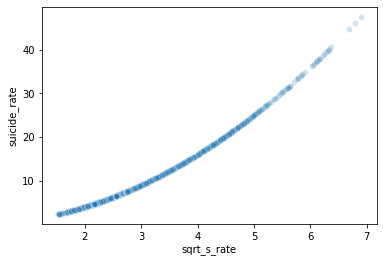

In [248]:
### EDA for Suicide Rate vs. Features ###
for feat in data.keys():
    if feat == 'suicide_rate':
        continue
    else:
        sns.scatterplot((data[feat]), data['suicide_rate'], alpha=0.2)
        plt.show()

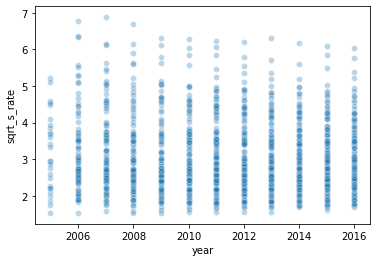

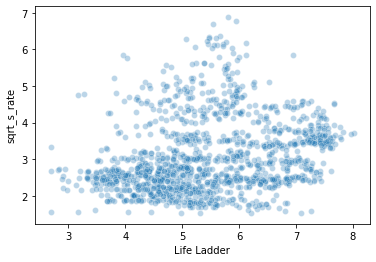

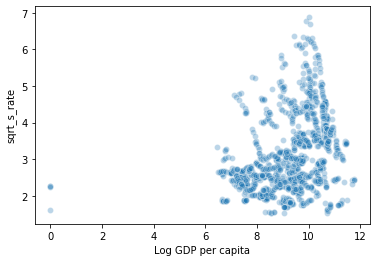

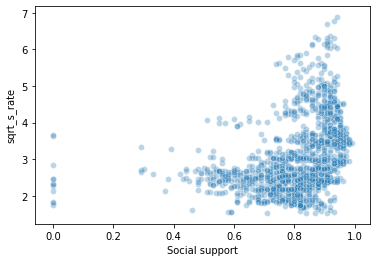

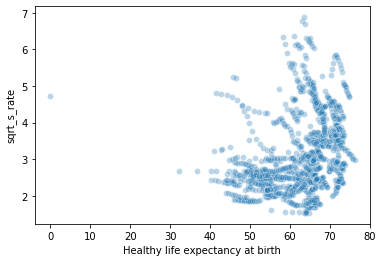

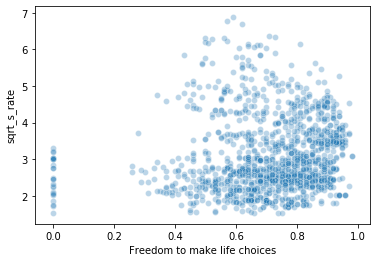

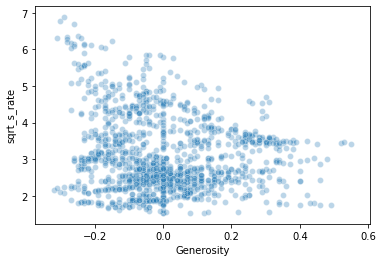

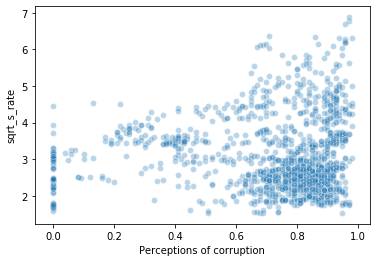

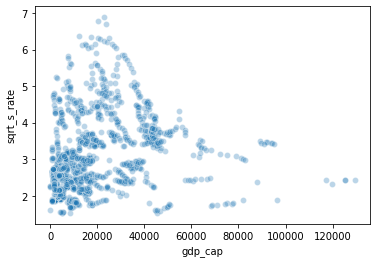

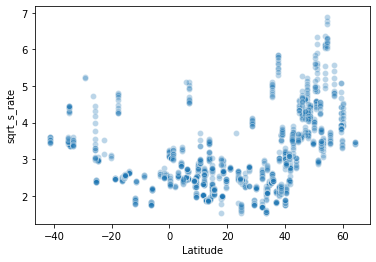

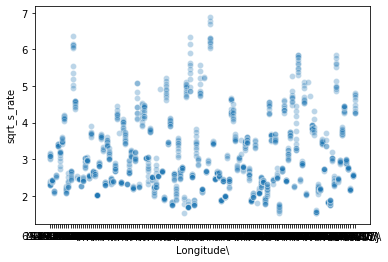

In [250]:
for feat in data.keys():
    if (feat == 'suicide_rate') or (feat == 'log_s_rate') or (feat == 'country') or (feat == 'sqrt_s_rate'):
        continue
    else:
        sns.scatterplot(data[feat], data['sqrt_s_rate'], alpha=0.3)
        plt.show()

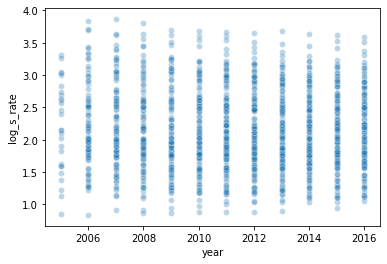

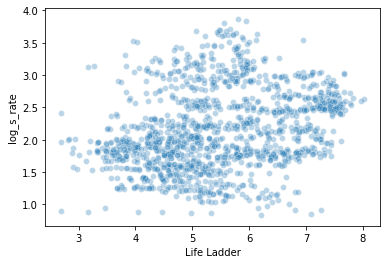

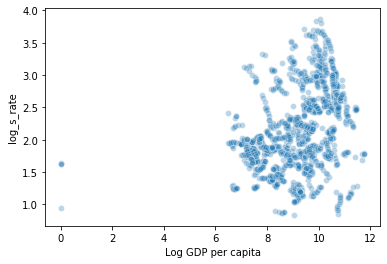

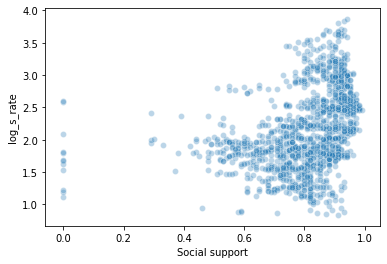

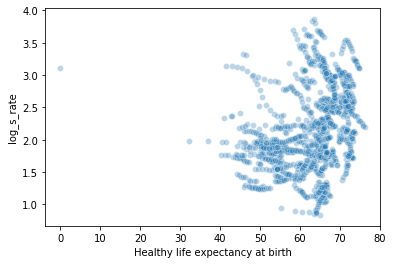

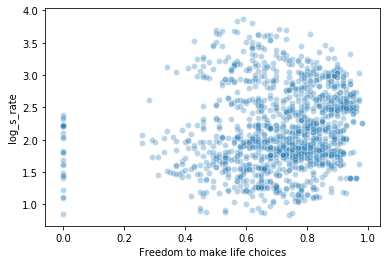

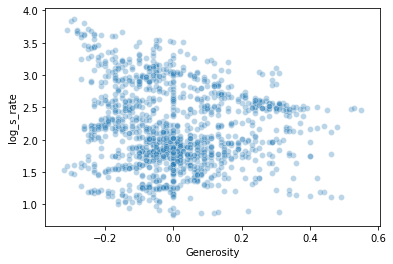

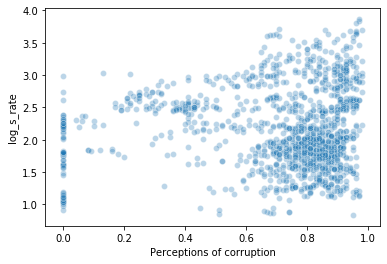

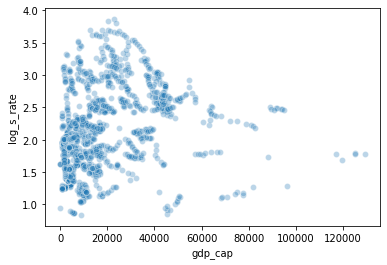

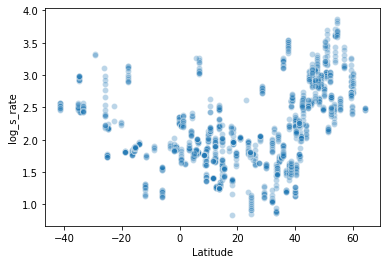

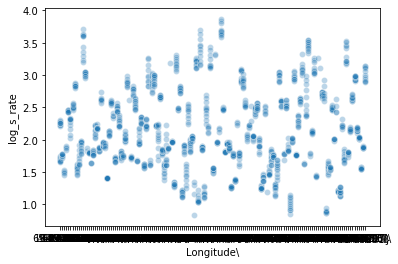

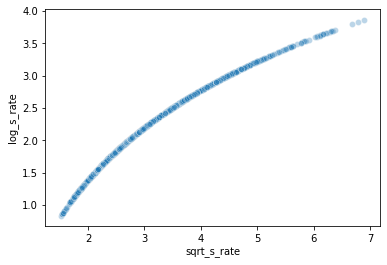

In [251]:
for feat in data.keys():
    if (feat == 'suicide_rate') or (feat == 'log_s_rate') or (feat == 'country'):
        continue
    else:
        sns.scatterplot(data[feat], data['log_s_rate'], alpha=0.3)
        plt.show()

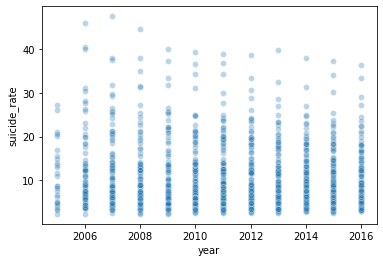

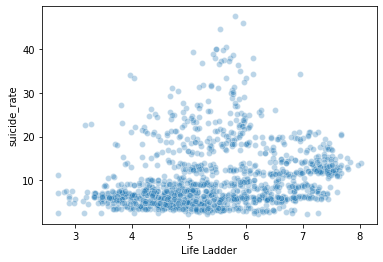

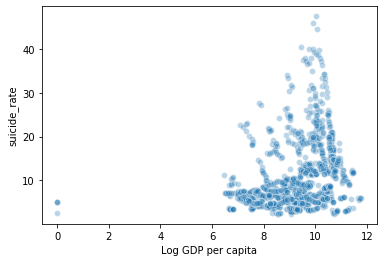

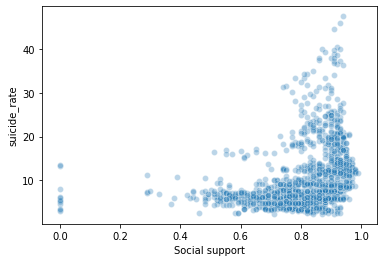

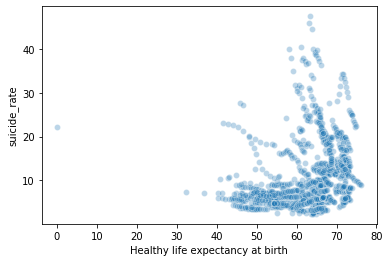

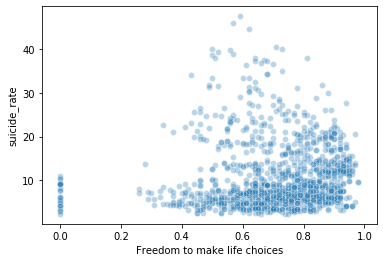

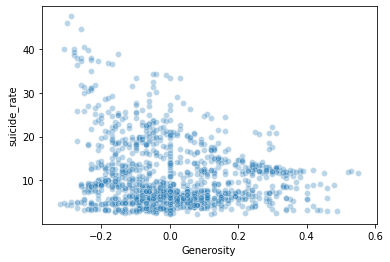

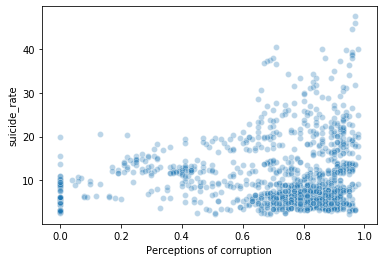

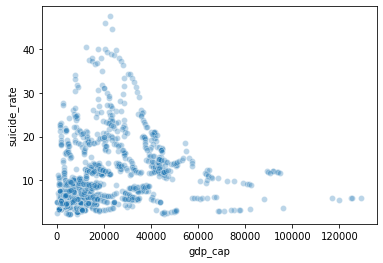

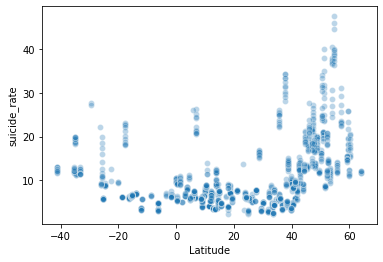

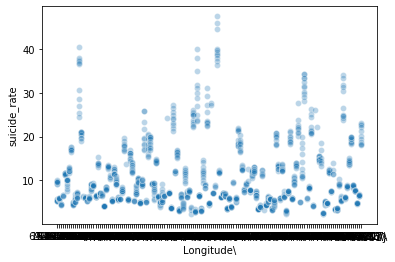

In [252]:
for feat in data.keys():
    if (feat == 'suicide_rate') or (feat == 'log_s_rate') or (feat == 'country') or (feat == 'sqrt_s_rate'):
        continue
    else:
        sns.scatterplot(data[feat], data['suicide_rate'], alpha=0.3)
        plt.show()

### Basic Regression Plots

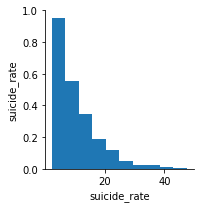

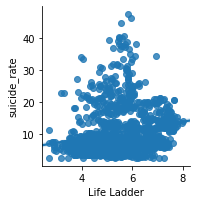

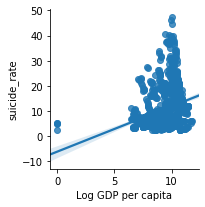

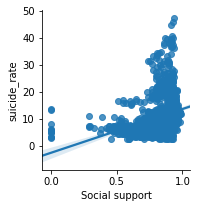

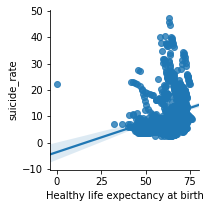

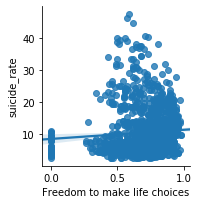

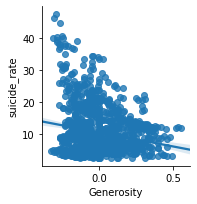

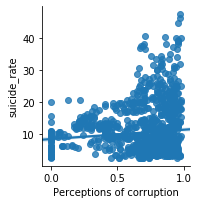

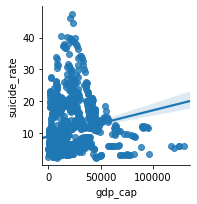

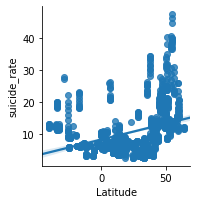

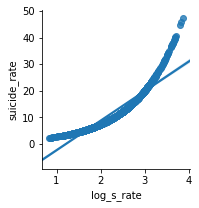

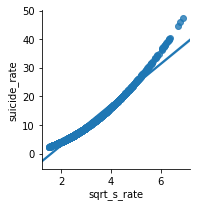

In [254]:
for i in data1:
    sns.pairplot(data=data1, y_vars=['suicide_rate'], x_vars=i, kind="reg", height=3)

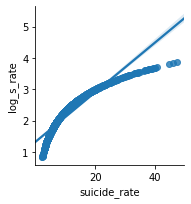

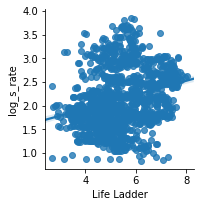

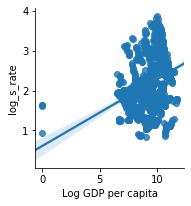

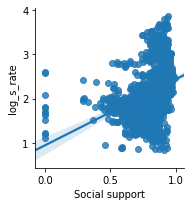

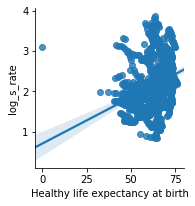

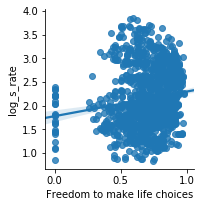

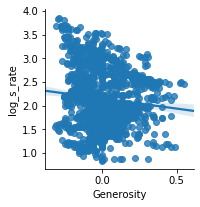

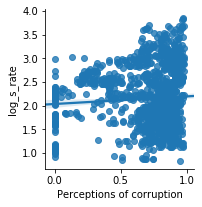

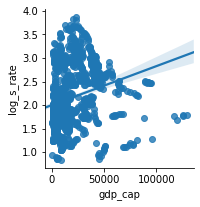

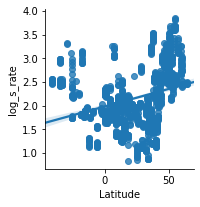

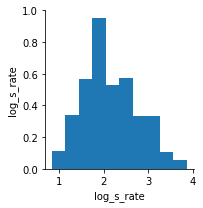

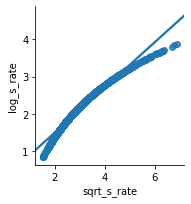

In [256]:
for i in data1:
    sns.pairplot(data=data1, y_vars=['log_s_rate'], x_vars=i, kind="reg", height=3)

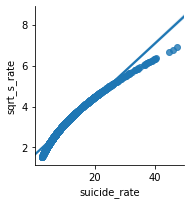

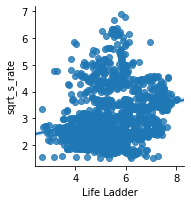

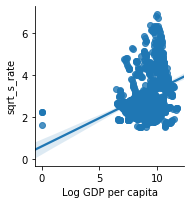

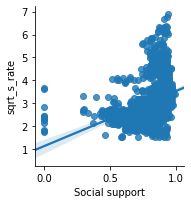

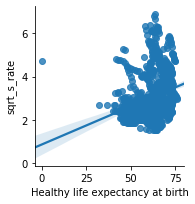

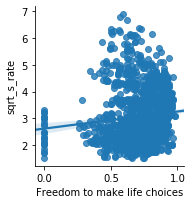

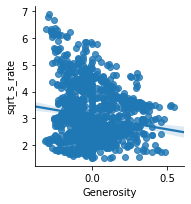

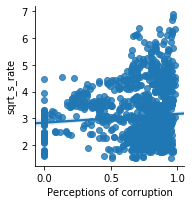

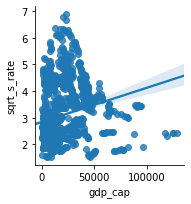

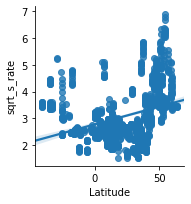

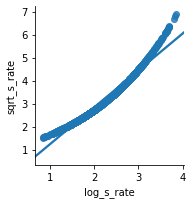

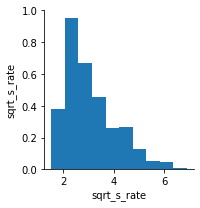

In [255]:
for i in data1:
    sns.pairplot(data=data1, y_vars=['sqrt_s_rate'], x_vars=i, kind="reg", height=3)

In [142]:
#prelim_model = ols(formula='suicide_rate~gdp_cap', data=data).fit()
#prelim_model.summary()

## Feature Engineering/Selection

## Model Selection

In [126]:
data.columns

Index(['country', 'year', 'suicide_rate', 'Life Ladder', 'Log GDP per capita',
       'Social support', 'Healthy life expectancy at birth',
       'Freedom to make life choices', 'Generosity',
       'Perceptions of corruption', 'gdp_cap', 'Latitude', 'Longitude\',
       'log_s_rate', 'sqrt_s_rate'],
      dtype='object')

In [124]:
target1 = data['suicide_rate']
target2 = data['log_s_rate']
target3 = data['sqrt_s_rate']
features = data[]

SyntaxError: invalid syntax (<ipython-input-124-85e6c3420294>, line 4)

In [361]:
data

,country,year,suicide_rate,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,gdp_cap,Latitude,Longitude\
0,Afghanistan,2008,5.73,3.72,7.17,0.45,50.80,0.72,0.18,0.88,1298.14,34.575503,69.240073\
1,Afghanistan,2009,5.63,4.40,7.33,0.55,51.20,0.68,0.20,0.85,1531.17,34.575503,69.240073\
2,Afghanistan,2010,5.54,4.76,7.39,0.54,51.60,0.60,0.13,0.71,1614.25,34.575503,69.240073\
3,Afghanistan,2011,5.46,3.83,7.42,0.52,51.92,0.50,0.17,0.73,1660.74,34.575503,69.240073\
4,Afghanistan,2012,5.39,3.78,7.52,0.52,52.24,0.53,0.24,0.78,1839.27,34.575503,69.240073\
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1325,Zimbabwe,2012,19.32,4.96,7.53,0.90,49.54,0.47,-0.08,0.86,1871.37,-17.825166,31.03351}
1326,Zimbabwe,2013,18.75,4.69,7.57,0.80,50.96,0.58,-0.08,0.83,1929.77,-17.825166,31.03351}
1327,Zimbabwe,2014,18.36,4.18,7.56,0.77,52.38,0.64,-0.05,0.82,1925.14,-17.825166,31.03351}
1328,Zimbabwe,2015,18.22,3.70,7.56,0.74,53.80,0.67,-0.10,0.81,1912.28,-17.825166,31.03351}
